The following code is glued together with input from several sources, mainly Kevin Mader's excellent "Attention on Pretrained-VGG16 for Bone Age" (https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age) and sinkie's "Keras data augmentation with multiple inputs" (https://www.kaggle.com/sinkie/keras-data-augmentation-with-multiple-inputs).

The code also includes the original work of Alisa Agafonova, Jon Raunkjær Søndergaard,
Yifan Liu Vestergaard & Mads Ehrhorn Kjær, masters students at NBI 2019, prepared for the course Big Data Analysis.

In [1]:
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, Flatten, concatenate
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.metrics import mean_absolute_error
from keras.applications import Xception
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


The hyperparameters are set with gefühl, because searching a grid for optimal values is not feasable when the training takes around six hours.

The image size is set to `299x299`, as that is what the pretrained network we use, Xception, expects.
Also, even though the images are grayscale, we use three channels (each just a copy of the grayscale values), again because Xception demands it to be so.

The validation fraction is 0.25; this fraction is again used when splitting the validation set into validation and testing. We unfortunately need to split the validation set, as we do not have any test set available with truth values.

Note that we run for 15 epochs, as that is about the range of computing time allowed.

In [2]:
# hyperparameters
EPOCHS = 15
LEARNING_RATE = 0.0006
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 256

#image parameters 
PIXELS = 299 #default for Xception
CHANNELS = 3
IMG_SIZE = (PIXELS, PIXELS)
IMG_DIMS = (PIXELS, PIXELS, CHANNELS)
VALIDATION_FRACTION = 0.25
SEED = 7834

The files are read in programmaticallly, with the ID given in the csv file used as pointer.
We do a check to see if the file is actually available in the folder; if not, it is removed.

In [3]:
path = '../input/boneage-training-dataset/boneage-training-dataset/'
path = '../input/'
train_path = path + 'boneage-training-dataset/boneage-training-dataset/'
test_path = path + 'boneage-test-dataset/boneage-test-dataset/'

df = pd.read_csv(path + 'boneage-training-dataset.csv')
files = [train_path + str(i) + '.png' for i in df['id']]
df['file'] = files
df['exists'] = df['file'].map(os.path.exists)

The distribution of the bone age is plotted, and we can see that it is imbalanced. This is corrected in the next cell.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


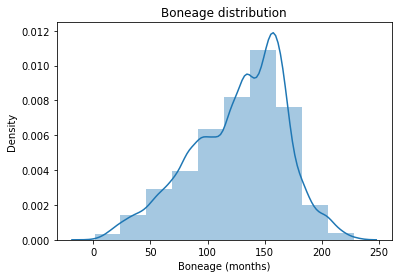

In [4]:
fig, ax = plt.subplots()
ax = sns.distplot(df['boneage'], bins=10)
ax.set(xlabel='Boneage (months)', ylabel='Density',
    title='Boneage distribution');

We convert the bone age to a z-score.
We also convert the male column (True / False) to integers 1 and 0.

The bone ages are cut into 10 bins (categories), and the full set is then split between a "raw" training set and a "raw" validation set, to be further processed afterwards. The split is stratified according to the bone age category, to ensure that we get entries from each category in the sets.

The raw training set is then converted to the final training set by randomly sampling 500 entries according to the bone age category, with replacement. This means that some images will appear more than once, but as we apply augmentations to the images (ie. we rotate, flip, etc.) this should have no impact.

Lastly, the raw validation set is split into a final validation set and a test set.

This process is from https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age.

In [5]:
boneage_mean = df['boneage'].mean()
boneage_div = 2 * df['boneage'].std()
df['boneage_zscore'] = df['boneage'].map(lambda x:
    (x - boneage_mean) / boneage_div)
df.dropna(inplace=True)

df['gender'] = df['male'].map(lambda x: 1 if x else 0)

df['boneage_category'] = pd.cut(df['boneage'], 10)
raw_train_df, raw_valid_df = train_test_split(df, test_size=VALIDATION_FRACTION,
  random_state=2018, stratify=df['boneage_category'])
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(
  lambda x: x.sample(500, replace=True)).reset_index(drop=True)
valid_df, test_df = train_test_split(raw_valid_df,
  test_size=VALIDATION_FRACTION, random_state=2019)

The new plot of the training set shows the distribution to be uniform over 10 bins, as expected.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


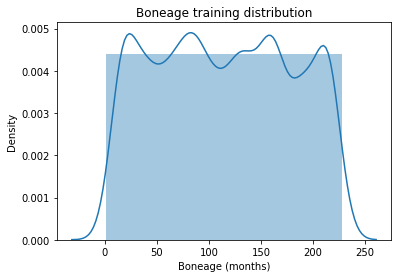

In [6]:
fig, ax = plt.subplots()
ax = sns.distplot(train_df['boneage'], bins=10)
ax.set(xlabel='Boneage (months)', ylabel='Density',
    title='Boneage training distribution');

The optimizer used during training.

In [7]:
optim = optimizers.Nadam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.0003)

Instructions for updating:
Colocations handled automatically by placer.


As callbacks we save the weights, create checkpoints, reduce the learning rate if the loss plateaues, and (of course!) early stopping.

In [8]:
weight_path = "{}_weights.best.hdf5".format('bone_age3')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
    patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5,
    min_lr=0.00006)
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)
callbacks_list = [checkpoint, early, reduceLROnPlat]

The step sizes are used for Keras' fit generator.

In [9]:
BATCH_SIZE_TEST = len(test_df) // 3
STEP_SIZE_TEST = 3
STEP_SIZE_TRAIN = len(train_df) // BATCH_SIZE_TRAIN
STEP_SIZE_VALID = len(valid_df) // BATCH_SIZE_VAL

Because we want to use the gender information as input to the neural network, we need the generator to take in two inputs; the image data and the gender information. This functionality is not given out of the box by Keras, and so the following wrapper ensures that both inputs are used, and handed over to the generator in the correct format.

Note that we use the same seed for both image and gender, to ensure that the generator fetches the same file for both.

This process is from https://www.kaggle.com/sinkie/keras-data-augmentation-with-multiple-inputs.

In [10]:
def gen_2inputs(imgDatGen, df, batch_size, seed, img_size):
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='boneage_zscore',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='gender',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

For the test images, we do not want shuffling, as we need to be able to compare with the test dataframe.

In [11]:
def test_gen_2inputs(imgDatGen, df, batch_size, img_size):
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='boneage_zscore',
        batch_size=batch_size, shuffle=False, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='gender',
        batch_size=batch_size, shuffle=False, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

We process images with the `ImageDataGenerator`. With the `ImageDataGenerator` we randomnly rotate, flip, shift, and zoom the images. This is a way to make sure every picture is different but in a random way. 

Next we define generators for both the training and validation set. The generator feeds the CNN model with the images in batches as we can't handle all the images at once. Our generator has to give two outputs: the images and the gender respectively for each image, in order for us to train on that feature as well, and therefore these use the generators previously defined.

In [12]:
train_idg = ImageDataGenerator(zoom_range=0.2,
                               fill_mode='nearest',
                               rotation_range=25,  
                               width_shift_range=0.25,  
                               height_shift_range=0.25,  
                               vertical_flip=False, 
                               horizontal_flip=True,
                               shear_range = 0.2,
                               samplewise_center=False, 
                               samplewise_std_normalization=False)

val_idg = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True)

train_flow = gen_2inputs(train_idg, train_df, BATCH_SIZE_TRAIN, SEED, IMG_SIZE)

valid_flow = gen_2inputs(val_idg, valid_df, BATCH_SIZE_VAL, SEED, IMG_SIZE)

test_idg = ImageDataGenerator()

test_flow = test_gen_2inputs(test_idg, test_df, 789, IMG_SIZE)

We want to be able to keep an eye on the loss while training. A sensible metric is the mean absolute error, but we need to convert it from a z-score to months, which is the job of the following function.

In [13]:
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div * in_gt, boneage_div * in_pred)

The optimizer used during training.

Creating the CNN: 
As is seen we have two inputs, one for images and one for gender. The images is run through a pretrained neural network Xception, attention is applied, and this is then fed to a layer that merges the information with the gender info.

Afterwards, this combined information is fed through some dense nodes, which finally gives the output.

The user may uncomment `model.summary()` to see the network layout; this is also saved as a png file later in the notebook.

In [14]:
# Two inputs. One for gender and one for images
in_layer_img = Input(shape=IMG_DIMS, name='input_img')
in_layer_gender = Input(shape=(1,), name='input_gender')

# Pretrained neural network
base = Xception(input_shape=IMG_DIMS, weights='imagenet', include_top=False)

pt_depth = base.get_output_shape_at(0)[-1]
pt_features = base(in_layer_img)
bn_features = BatchNormalization()(pt_features)

# Attention layer
attn_layer = Conv2D(64, kernel_size=(1,1), padding='same', activation='relu')(bn_features)
attn_layer = Conv2D(16, kernel_size=(1,1), padding='same', activation='relu')(attn_layer)
attn_layer = LocallyConnected2D(1, kernel_size=(1,1), padding='valid',
    activation = 'sigmoid')(attn_layer)

# Applying attention to all features coming out of bn_features
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size=(1,1), padding='same',
    activation='linear', use_bias=False, weights=[up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])

# Global Average Pooling 2D
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
gap = Lambda(lambda x: x[0]/x[1], name='RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))

# This is where gender enters in the model
feature_gender = Dense(32, activation='relu')(in_layer_gender)
feature = concatenate([dr_steps, feature_gender], axis=1)

o = Dense(1000, activation='relu')(feature)
o = Dense(1000, activation='relu')(o)
o = Dense(1, activation='linear')(o)

model = Model(inputs=[in_layer_img, in_layer_gender], outputs=o)

model.compile(loss='mean_absolute_error', optimizer=optim, metrics=[mae_months])

model.summary()

83689472/83683744 [==============================] - 8s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 10, 10, 2048) 8192        xception[1][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)           

Now we fit the model, feeding it both the generators, the constants and the callback list.

In [15]:
model_history = model.fit_generator(generator=train_flow,
    steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_flow,
    validation_steps=STEP_SIZE_VALID, epochs=EPOCHS,
    callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
Found 2364 images.
Found 2364 images.
Found 10000 images.
Found 10000 images.
312/312 [==============================] - 1111s 4s/step - loss: 0.2617 - mae_months: 21.5545 - val_loss: 0.2137 - val_mae_months: 17.6009

Epoch 00001: val_loss improved from inf to 0.21370, saving model to bone_age3_weights.best.hdf5
Epoch 2/15
312/312 [==============================] - 1000s 3s/step - loss: 0.1659 - mae_months: 13.6670 - val_loss: 0.1278 - val_mae_months: 10.5240

Epoch 00002: val_loss improved from 0.21370 to 0.12777, saving model to bone_age3_weights.best.hdf5
Epoch 3/15
312/312 [==============================] - 1027s 3s/step - loss: 0.1451 - mae_months: 11.9512 - val_loss: 0.1206 - val_mae_months: 9.9354

Epoch 00003: val_loss improved from 0.12777 to 0.12063, saving model to bone_age3_weights.best.hdf5
Epoch 4/15
312/312 [==============================] - 1045s 3s/step - loss: 0.1355 - mae_months: 11.1579 - val_loss: 0.1310 - 

We save the model as a png file, and the loss history as a csv file. I'm not sure what the best way is to download it after the notebook has run; I personally commit the code, and the use the Kaggle API (see https://github.com/Kaggle/kaggle-api), which offers the `$ kaggle kernels output` command, that fetches the files from the latest commit.

In [16]:
loss_history = model_history.history['loss']
from keras.utils import plot_model
plot_model(model, to_file='model.png')
history_df = pd.DataFrame.from_dict(model_history.history)
history_df.to_csv('loss_history.csv')

The test set is retrieved.

In [17]:
test_X, test_Y = next(test_flow)

Found 789 images.
Found 789 images.


Plotting four images with test result.

789/789 [==============================] - 9s 11ms/step


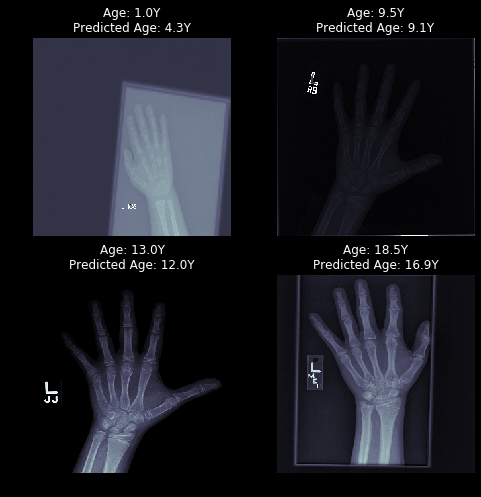

In [18]:
plt.style.use("dark_background")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
pred_Y = boneage_div*model.predict(test_X, batch_size = 263, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

ord_idx = np.argsort(test_Y)
ord_idx = ord_idx[np.linspace(0, len(ord_idx)-1, 4).astype(int)] # take 8 evenly spaced ones
fig, m_axs = plt.subplots(2, 2, figsize = (8, 8))
for (idx, c_ax) in zip(ord_idx, m_axs.flatten()):
    cur_img = test_X[0][idx:(idx+1)]
    c_ax.imshow(cur_img[0, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/12.0, 
                                                           pred_Y[idx]/12.0))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

Saving test error.

In [19]:
from sklearn.metrics import mean_absolute_error as mean_abs
test_error = mean_abs(test_Y, pred_Y)
test_error = boneage_div * test_error + boneage_mean
test_error = str(test_error)

Outfile=open('test_error.txt','w')